In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import math
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [2]:
from helpers import load_data, preprocess_data

path_dataset = "data/data_train.csv"
ratings = load_data(path_dataset)

number of items: 1000, number of users: 10000


### Plot the number of ratings per movie and user

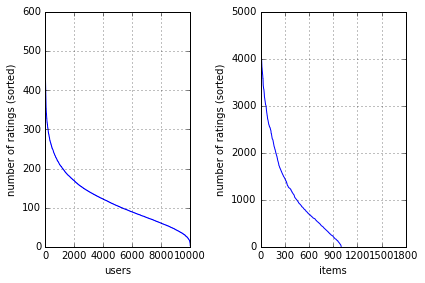

min # of items per user = 3, min # of users per item = 8.


In [3]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Split the data into a train and test set

In [4]:
from plots import plot_train_test_data
from helpers import split_data

valid_ratings, train_unfiltered, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=0, p_test=0.1)


Total number of nonzero elements in original data:1176952
Total number of nonzero elements in train data:1058987
Total number of nonzero elements in test data:117965


In [5]:
from outliers_filtering import *
#d = disagreements(train_unfiltered)
#plot_disagreements(d)
#train = filter_outliers(train_unfiltered,d)
#nfiltered = train_unfiltered.nnz - train.nnz
#print("number of filtered ratings : {}".format(nfiltered))
train = train_unfiltered

In [7]:
from outliers_filtering import threshold_tests
#threshold_tests(d, train_unfiltered, valid_ratings, test)

## Implementing Baselines 

### Use the global mean to do the prediction

In [ ]:
from helpers import calculate_mse
from baselines import baseline_global_mean, compute_rmse

train_mean, test_mean = baseline_global_mean(train, test)
pred = np.ones(train.shape) * train_mean
test_pred = np.ones(test.shape) * test_mean


rmse_test = compute_rmse(test, test_pred)
rmse_submission = compute_rmse(valid_ratings, pred)
print(rmse_test)
print(rmse_submission)

### Use the user means as the prediction

In [ ]:
from baselines import baseline_user_mean

train_means, test_means = baseline_user_mean(train, test)
train_means_list = train_means.tolist()
pred = np.ones(train.shape)
for col in range(train.shape[1]):
    pred[:,col] *= train_means_list[0][col]
test_means_list = test_means.tolist()
test_pred = np.ones(test.shape)
for col in range(test.shape[1]):
    test_pred[:,col] *= test_means_list[0][col]

rmse_test = compute_rmse(test, test_pred)
rmse_submission = compute_rmse(valid_ratings, pred)
print(rmse_test)
print(rmse_submission)

### Use the item means as the prediction

In [ ]:
from baselines import baseline_item_mean
from helpers import exportSubmission

train_means, test_means = baseline_item_mean(train, test)
train_means_list = train_means.tolist()
pred = np.ones(train.shape)
for col in range(train.shape[0]):
    pred[col,:] *= train_means_list[col]
test_means_list = test_means.tolist()
test_pred = np.ones(test.shape)
for col in range(test.shape[0]):
    test_pred[col,:] *= test_means_list[col]

rmse_test = compute_rmse(test, test_pred)
rmse_submission = compute_rmse(valid_ratings, pred)
print(rmse_test)
print(rmse_submission)

### Learn the Matrix Factorization using SGD

#### Initialize matrix factorization

Compute the cost by the method of matrix factorization.


In [11]:
from matrix_factorization import multiple_matrix_factorization_SGD
from helpers import pick_lowest_rmse
# set seed
np.random.seed(988)
results = multiple_matrix_factorization_SGD(train, test, num_epochs=500, ntries=5)
rmse, user_features, item_features = pick_lowest_rmse(test, results, test.nonzero())
print(rmse)

iter: k = 30, RMSE on training set: 1.2826366743059094.
learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 2.0818817363770665.
iter: 0, RMSE on test set: 2.05332580310938.
iter: 10, RMSE on training set: 1.1251553858281957.
iter: 10, RMSE on test set: 1.0943798952219048.
iter: 20, RMSE on training set: 1.0554216877085905.
iter: 20, RMSE on test set: 1.0250965470217406.
iter: 30, RMSE on training set: 1.0339823298639654.
iter: 30, RMSE on test set: 1.004488120680532.
iter: 40, RMSE on training set: 1.0235905548177717.
iter: 40, RMSE on test set: 0.9948556567251996.
iter: 50, RMSE on training set: 1.0176385848454204.
iter: 50, RMSE on test set: 0.9894089039808389.
iter: 60, RMSE on training set: 1.0136608016782331.
iter: 60, RMSE on test set: 0.985965662618629.
iter: 70, RMSE on training set: 1.0105940222751648.
iter: 70, RMSE on test set: 0.9834988039647943.
iter: 80, RMSE on training set: 1.0082909805137577.
iter: 80, RMSE on test set: 0.9818013266345172.
iter: 

KeyboardInterrupt: 

In [ ]:
from helpers import exportSubmission
pred =  (item_features @ user_features.T)
exportSubmission("data/submission_MF.csv", pred)

In [ ]:
from matrix_factorization import matrix_factorization_SGD
from helpers import compute_error
user_features_list = []
item_features_list = []
errors = []
for i in np.arange(1, 10, 1):
    user_features, item_features = matrix_factorization_SGD(train, test, num_epochs = 1000, num_features = i)
    user_features_list.append(user_features)
    item_features_list.append(item_features)
    error = compute_error(test, user_features, item_features, test.nonzero())
    errors.append(error)


In [ ]:
from plots import visualization
visualization(np.arange(5, 40, 5),errors,errors)
print(errors)

In [ ]:
from plots import visualization
visualization(np.arange(1, 10, 1),errors,errors)
print(errors)

In [ ]:
user_features = user_features_list[2]
item_features = item_features_list[2]
compute_error(test, user_features, item_features, test.nonzero())

iter: k = 20, RMSE on training set: 1.3574832877491125.
learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 2.071044015710499.
iter: 0, RMSE on test set: 2.0364625940219345.
iter: 10, RMSE on training set: 1.1129088968329377.
iter: 10, RMSE on test set: 1.0773024582229975.
iter: 20, RMSE on training set: 1.0538074509529618.
iter: 20, RMSE on test set: 1.0181277331301066.
iter: 30, RMSE on training set: 1.0349213234680046.
iter: 30, RMSE on test set: 0.9992433333279275.
iter: 40, RMSE on training set: 1.025361379616613.
iter: 40, RMSE on test set: 0.9898067843289253.
iter: 50, RMSE on training set: 1.0195218381022202.
iter: 50, RMSE on test set: 0.9839763378594184.
iter: 60, RMSE on training set: 1.0154390186993305.
iter: 60, RMSE on test set: 0.9798829720423876.
iter: 70, RMSE on training set: 1.0124627360439271.
iter: 70, RMSE on test set: 0.9770023098379608.
iter: 80, RMSE on training set: 1.0100328762831678.
iter: 80, RMSE on test set: 0.9745158991631423.
iter

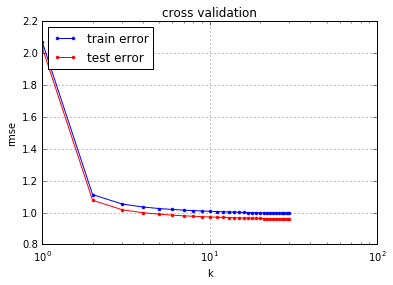

In [13]:
from matrix_factorization import matrix_factorization_SGD
user_features, item_features = matrix_factorization_SGD(valid_ratings, test, num_epochs = 300, num_features = 20)

In [14]:
np.save("data/features/best2_user_features.npy", user_features)
np.save("data/features/best2_item_features.npy", item_features)

### Learn the Matrix Factorization using Alternating Least Squares

In [ ]:
def update_user_feature(
        train, item_features, lambda_user,
        nnz_items_per_user, nz_user_itemindices):
    """update user feature matrix."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # update and return user feature.
    # ***************************************************
    raise NotImplementedError

def update_item_feature(
        train, user_features, lambda_item,
        nnz_users_per_item, nz_item_userindices):
    """update item feature matrix."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # update and return item feature.
    # ***************************************************
    raise NotImplementedError

In [ ]:
from helpers import build_index_groups


def ALS(train, test):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    stop_criterion = 1e-4
    change = 1
    error_list = [0, 0]
    
    # set seed
    np.random.seed(988)

    # init ALS
    user_features, item_features = init_MF(train, num_features)
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # start you ALS-WR algorithm.
    # ***************************************************
    raise NotImplementedError

ALS(train, test)

In [ ]:
###Computing prediction

In [ ]:
pred = np.ones(valid_ratings.shape)
for col in range(valid_ratings.shape[0]):
    pred[col,:] *= ratings_means_list[col]
    
exportSubmission("data/final_submission.csv", pred)